In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import glob
import os
# from alive_progress import alive_it
from tqdm import tqdm

/var/folders/ff/wvby4kh52j96myw15h33jjk40000gn/T/ipykernel_19704/4136345464.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("data/v1.0.0.csv")
df

,image_path,subject_ID,image_number,gender,glasses,eye_state,reflections,image_quality,sensor_type,label
0,/Users/I748920/Desktop/secure-face-capture-pyt...,s0030,663,0,0,1,0,1,1,open
1,/Users/I748920/Desktop/secure-face-capture-pyt...,s0030,486,0,0,1,0,1,1,open
2,/Users/I748920/Desktop/secure-face-capture-pyt...,s0030,384,0,0,1,0,1,1,open
3,/Users/I748920/Desktop/secure-face-capture-pyt...,s0030,782,0,0,1,0,1,1,open
4,/Users/I748920/Desktop/secure-face-capture-pyt...,s0030,764,0,0,1,0,1,1,open
...,...,...,...,...,...,...,...,...,...,...
84893,/Users/I748920/Desktop/secure-face-capture-pyt...,s0016,534,1,0,0,1,1,1,close
84894,/Users/I748920/Desktop/secure-face-capture-pyt...,s0016,1793,1,0,1,0,1,1,open
84895,/Users/I748920/Desktop/secure-face-capture-pyt...,s0016,331,1,0,0,0,1,1,close
84896,/Users/I748920/Desktop/secure-face-capture-pyt...,s0016,709,1,0,0,0,1,1,close


In [3]:
df.columns

Index(['image_path', 'subject_ID', 'image_number', 'gender', 'glasses',
       'eye_state', 'reflections', 'image_quality', 'sensor_type', 'label'],
      dtype='object')

In [4]:
len(df)

84898

In [5]:
df.iloc[:10000].label.value_counts()

label
close    5375
open     4625
Name: count, dtype: int64

In [87]:
df = df.iloc[:1000]

In [89]:
# train test split
from sklearn.model_selection import train_test_split

train,test = train_test_split(df,test_size=0.1,shuffle=True,random_state=1,stratify=df[['label','gender', 'glasses','reflections', 'image_quality']])
train,val = train_test_split(train,test_size=2/7,shuffle=True,random_state=1,stratify=train[['label','gender', 'glasses','reflections', 'image_quality']])

In [91]:
len(train),len(val),len(test)

train.label.value_counts()/len(train),val.label.value_counts()/len(val),test.label.value_counts()/len(test)

(label
 open     0.758567
 close    0.241433
 Name: count, dtype: float64,
 label
 open     0.75969
 close    0.24031
 Name: count, dtype: float64,
 label
 open     0.76
 close    0.24
 Name: count, dtype: float64)

In [93]:
# find what the min_dim for the dataset is, that should resize all images to a number close to that, so that small images are not upsampled to larger dim instead
min_dim = np.float64("inf")
for i,row in tqdm(df.sample(n=10000).iterrows()):
    dims = plt.imread(row['image_path']).shape
    dims = min(dims)
    if dims<min_dim:
        min_dim=dims

min_dim

ValueError: Cannot take a larger sample than population when 'replace=False'

should use a try except function and read all the files to ensure that all images are actually readable and not corrupt, should also set a threshold on min_dims so that weird images that are too small arent used

In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, RandomCrop, ColorJitter, Normalize, InterpolationMode

def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
    

class EyeDataset(Dataset):
    def __init__(self,df,split_type,input_dim):
        self.split_type = split_type
        self.input_dim = input_dim

        self.image_paths = df.image_path.tolist()
        self.labels = df.label.tolist()
        self.mapping = {
            "close":0,
            "open":1,
        }
        
    def __len__(self):
        return len(self.image_paths)       
        
    def __getitem__(self,ind):
        image = load_image(self.image_paths[ind])
        label = self.mapping[self.labels[ind]]

        if self.split_type=='train':
            # apply train transforms
            train_transforms = Compose([
                ToTensor(),  # Converts to torch tensor and normalizes to [0,1]
                Resize((self.input_dim, self.input_dim)),  # Resize to the specified input dimensions
                RandomHorizontalFlip(),  # Randomly flip the image horizontally with a probability of 0.5
                RandomRotation(10,interpolation=InterpolationMode.BILINEAR),  # Randomly rotate the image by ±10 degrees
                RandomCrop(self.input_dim, padding=4),  # Randomly crop the image with padding
                ColorJitter(brightness=0.2, contrast=0.2),  # Slightly adjust brightness and contrast
                Normalize(mean=[0], std=[1])  
            ])
            image = train_transforms(image)
        
        else:
            # apply val and test transforms, resize, normalise, totensor
            val_transforms = Compose([
                ToTensor(), # converts to type torch tensor and normalise to [0,1]
                Resize((self.input_dim,self.input_dim)),
                Normalize(mean=[0], std=[1])  
            ])
            image = val_transforms(image)
       
        
        return image,label

torch.Size([1, 50, 50])


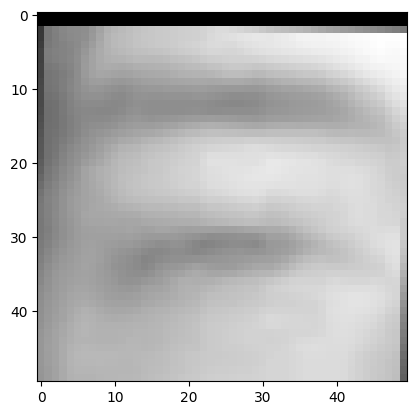

In [96]:
sample_dataset = EyeDataset(
    df=val,
    split_type='train',
    input_dim=50
)

print(sample_dataset[0][0].shape)
plt.imshow(sample_dataset[2][0].permute(1,2,0),cmap='gray')
plt.show()

torch.Size([1, 50, 50])


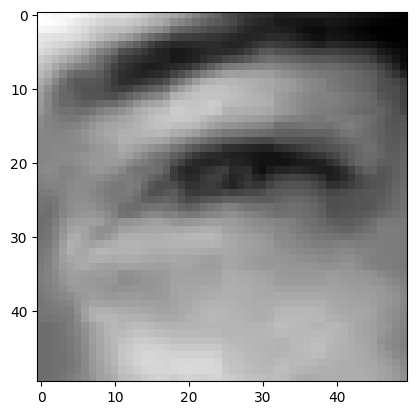

In [98]:
sample_dataset = EyeDataset(
    df=val,
    split_type='test',
    input_dim=50
)

print(sample_dataset[0][0].shape)
plt.imshow(sample_dataset[0][0].permute(1,2,0),cmap='gray')
plt.show()

In [100]:
# initialise dataset
input_dim = 256

train_dataset = EyeDataset(
    df=train,
    split_type='train',
    input_dim=input_dim
)

val_dataset = EyeDataset(
    df=val,
    split_type='val',
    input_dim=input_dim
)

test_dataset = EyeDataset(
    df=test,
    split_type='test',
    input_dim=input_dim
)

In [102]:
test_dataset.__len__()

100

In [104]:
# dataloader

batch_size = 128

from torch.utils.data import DataLoader

train_dl = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle=True,
)

val_dl = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    shuffle=False,
)

test_dl = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle=False,
)

In [106]:
batch = next(iter(train_dl))
x_batch,y_batch = batch
x_batch.shape,y_batch.shape

(torch.Size([128, 1, 256, 256]), torch.Size([128]))

train_dl


15it [00:00, 2373.69it/s]


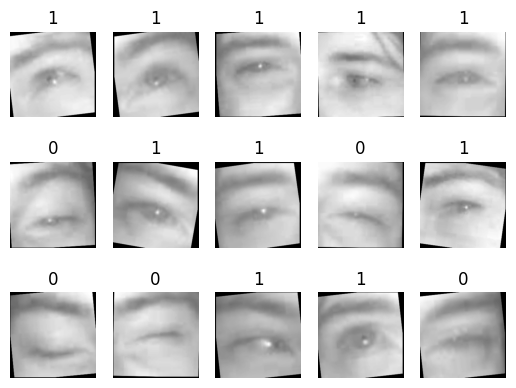

In [107]:
print("train_dl")

rows,cols=3,5
fig,ax=plt.subplots(rows,cols)

for i,ind in tqdm(enumerate(np.random.randint(0,127,rows*cols))):
    img,label = x_batch[ind],y_batch[ind]

    plt.subplot(rows,cols,i+1)
    plt.imshow(img.permute(1,2,0),cmap='gray')
    plt.title(label.item())
    plt.axis('off')

plt.show()

In [108]:
batch = next(iter(val_dl))
x_batch,y_batch = batch
x_batch.shape,y_batch.shape

(torch.Size([128, 1, 256, 256]), torch.Size([128]))

val_dl


15it [00:00, 2636.16it/s]


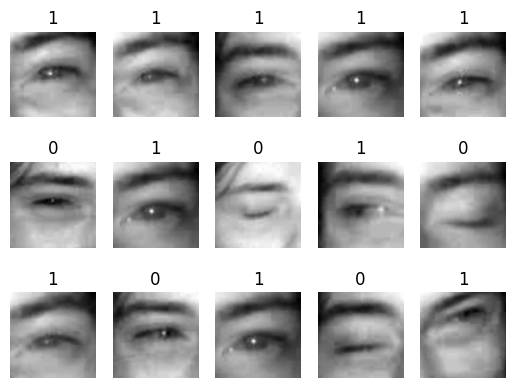

In [109]:
print("val_dl")

rows,cols=3,5
fig,ax=plt.subplots(rows,cols)

for i,ind in tqdm(enumerate(np.random.randint(0,127,rows*cols))):
    img,label = x_batch[ind],y_batch[ind]

    plt.subplot(rows,cols,i+1)
    plt.imshow(img.permute(1,2,0),cmap='gray')
    plt.title(label.item())
    plt.axis('off')

plt.show()

In [110]:
batch = next(iter(test_dl))
x_batch,y_batch = batch
x_batch.shape,y_batch.shape

(torch.Size([100, 1, 256, 256]), torch.Size([100]))

test_dl


6it [00:00, 1380.54it/s]


IndexError: index 103 is out of bounds for dimension 0 with size 100

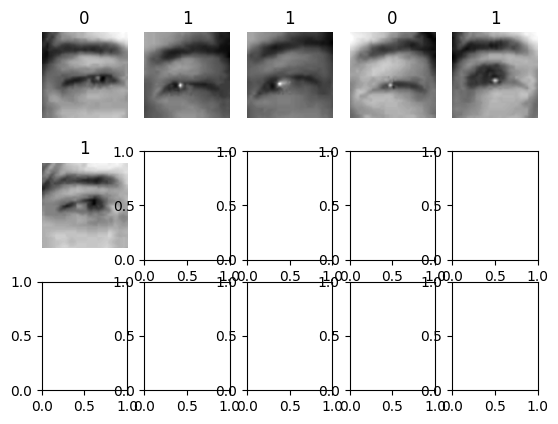

In [111]:
print("test_dl")

rows,cols=3,5
fig,ax=plt.subplots(rows,cols)

for i,ind in tqdm(enumerate(np.random.randint(0,127,rows*cols))):
    img,label = x_batch[ind],y_batch[ind]

    plt.subplot(rows,cols,i+1)
    plt.imshow(img.permute(1,2,0),cmap='gray')
    plt.title(label.item())
    plt.axis('off')

plt.show()

# train

In [ ]:
# PyTorch for creating and training the neural network
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data.dataset import random_split

# platform for getting the operating system
# import platform

# torchvision for loading and transforming the dataset
import torchvision
import torchvision.transforms as transforms

# ReduceLROnPlateau for adjusting the learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau

# numpy for numerical operations
import numpy as np

# matplotlib for plotting
import matplotlib.pyplot as plt

In [189]:
class test:
    def __init__(self):
        self.list = []

    def generate(self):
        return [1,2,3]

    def __generate(self):
        return [1,2,3]
        
    def __generate__(self): 
        # dunder
        return [1,2,3]

test = test()

In [191]:
test.generate()

[1, 2, 3]

In [193]:
test.__generate()

AttributeError: 'test' object has no attribute '__generate'

In [195]:
test.__generate__()

[1, 2, 3]

In [ ]:
class AlexNet(nn.Module):
    """
    AlexNet model

    Args:
        n_dims (int): number of RGB channels. Set to 3 for RGB, 1 for Grayscale image. Default is 3.
        num_classes (int): number of classes in the dataset. Default is 1000.
    """
    def __init__(self, n_dims=3, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(n_dims, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        """
        Forward pass of the model
        
        Args:
            x (torch.Tensor): input tensor of shape (N, C, H, W)
        
        Returns:
            torch.Tensor: output tensor of shape (N, num_classes)
        """
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
sample_model = AlexNet(n_dims=1,num_classes=2)

sample_input = torch.tensor(np.random.random((1,1,128,128)),dtype=torch.float32)
sample_model(sample_input)

In [ ]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after

    Args:
    -----
        patience (int): Number of epochs to wait before stopping the training.
        verbose (bool): If True, prints a message for each epoch where the loss
                        does not improve.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        """
        Args:
        -----
            val_loss (float): The validation loss to check if the model performance improved.
        
        Returns:
        --------
            bool: True if the loss did not improve, False if it improved.
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

edit or create a simple Early Stopping class here

In [142]:
class Trainer:
    """
    Trainer class to train the model.

    Args:
    -----
        model (nn.Module): Neural network model.
        criterion (torch.nn.modules.loss): Loss function.
        optimizer (torch.optim): Optimizer.
        device (torch.device): Device to run the model on.
        patience (int): Number of epochs to wait before stopping the training.
    """
    def __init__(self, model, criterion, optimizer, device, patience=5):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.early_stopping = EarlyStopping(patience=patience)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=3, verbose=True, factor=0.5, min_lr=1e-6)
        self.train_losses = []
        self.val_losses = []
        self.gradient_norms = []

    def train(self, train_loader, val_loader, epochs):
        """
        Train the model.
        
        Args:
        -----
            train_loader (torch.utils.data.DataLoader): DataLoader for training dataset.
            val_loader (torch.utils.data.DataLoader): DataLoader for validation dataset.
            epochs (int): Number of epochs to train the model.
        """
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0  # Initialize running loss for this epoch
            
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()  # Accumulate the loss for this batch
    
            epoch_loss = running_loss / len(train_loader)  # Calculate the average loss for this epoch
            self.train_losses.append(epoch_loss)  # Append the average loss to the list

            val_loss = self.get_val_loss(val_loader)
            self.val_losses.append(val_loss)
            self.scheduler.step(val_loss)
            self.early_stopping(val_loss)

            # Log the training and validation loss
            print(f'Epoch {epoch+1}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

            if self.early_stopping.early_stop:
                print("Early stopping")
                break

    def get_val_loss(self, val_loader):
        """
        Calculate validation loss of the model on the validation dataset. Can also use for test, pass in test_dl instead.

        Args:
        -----
            val_loader (torch.utils.data.DataLoader): DataLoader for val dataset.

        Returns:
        --------
            float: Average loss on the val dataset.
        """
        self.model.eval()
        running_loss = 0.0  # Initialize running loss for this epoch
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()  # Accumulate the loss for this batch

        average_loss = running_loss / len(val_loader)  # Calculate the average loss over all batches
        return average_loss
    
    def get_accuracy(self, test_loader):
        """
        Calculate the accuracy of the model on the test dataset.

        Args:
        -----
            test_loader (torch.utils.data.DataLoader): DataLoader for test dataset.

        Returns:
        --------
            float: Accuracy of the model on the test dataset.
        """
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        acc = correct / total
        return acc

    def plot_losses(self):
        # Plot
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.legend()
        plt.grid()
        plt.title('Losses vs Epochs')

    def moving_average(self, data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    def plot_losses_moving_average(self, window_size=100):
        # Compute moving averages
        train_losses_smooth = self.moving_average(self.train_losses, window_size)
        val_losses_smooth = self.moving_average(self.val_losses, window_size)

        # Plot
        plt.plot(train_losses_smooth, label='Train Loss')
        plt.plot(val_losses_smooth, label='Validation Loss')
        plt.legend()
        plt.grid()
        plt.title('Losses')

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [151]:
model = AlexNet(n_dims=1, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = Trainer(model, criterion, optimizer, device, patience=7)

# Train the model
trainer.train(train_dl, val_dl, epochs=10)

/Users/I748920/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 0.6622, Validation Loss: 0.6934
Epoch 2, Training Loss: 0.7071, Validation Loss: 0.7072
Epoch 3, Training Loss: 0.7383, Validation Loss: 0.7357
Epoch 4, Training Loss: 0.7702, Validation Loss: 0.7658
Epoch 5, Training Loss: 0.7949, Validation Loss: 0.7891
Epoch 6, Training Loss: 0.3213, Validation Loss: 0.7981
Epoch 7, Training Loss: 0.3083, Validation Loss: 0.8115
Epoch 8, Training Loss: 0.2892, Validation Loss: 0.8267
Early stopping


In [152]:
# Evaluate the model on the test set
test_loss = trainer.get_val_loss(test_dl)
print(f'Test Loss: {test_loss:.4f}')

# Calculate the accuracy on the test set
accuracy = trainer.get_accuracy(test_dl)
print(f'Test Accuracy: {accuracy :.2%}%')

Test Loss: 0.5513
Test Accuracy: 76.00%%


think of new methods to use for project evaluation, e.g. evaluate, inferenence, get test loss (use same function as val loss but would be good to seperate for logic flow) -evaluate is on entire test_dl, inference is one a new image, doesnt take in y labels

clean code - break down any big functions into smaller pieces

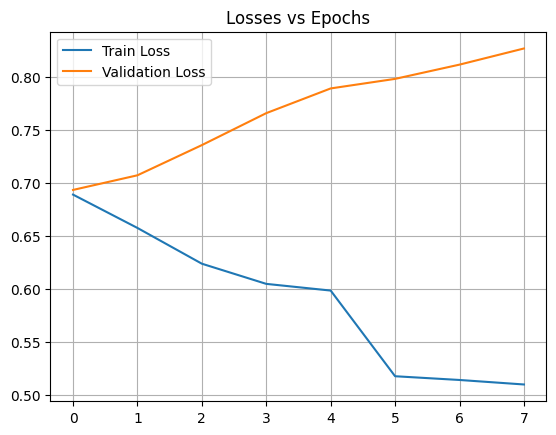

In [153]:
trainer.plot_losses()